# Аналитика активности пользователей в обучающем игровом приложении


В базе представлены данные об активности пользователей в обучающем игровом
приложении. Необходимо рассчитать метрики:
* Retention и время, которое ученики проводят в приложении
* Как ученики переходят с уровня на уровень
* Метрики монетизации для всей когорты
* Где ученики совершают больше всего платежей?
* Где ученики совершают первые платежи?
* дополнительные метрики для отслеживания и необходимые дополнительные данные для их расчета


## Оглавление
* [Загрузка и предобработка данных](#load_data)
* [Исследовательский анализ данных (EDA)](#eda)
  * [Временное исследование данных](#eda_time)
  * [Исследование уровней пользователей](#eda_levels)
  * [Добавление новых столбцов](#new_columns)
  * [Создание профилей пользователей](#profiles)
* [Метрики вовлечённости](#engagement_rate)
  * [Активация в приложении](#ER_activtion)
  * [Факт "залипания" в приложении (stickiness rate)](#stickiness_rate)
  * [Retention Rate](#RR)
* [Метрики монетизации](#AR)
  * [ARPU (Average Revenue Per User)](#ARPU)
  * [ARPPU (Average Revenue Per Paying User)](#ARPPU)
  * [AOV (Average order value)](#AOV)
  * [Процент платящих пользователей](#Paying_share)
  * [Процент повторных покупок](#second_buy)
  * [Как пользователи совершали покупки](#buy_profiles)
  * [Анализ второй и следующих покупок](#next)
* [Дополнительные метрики, требующие дополнительных данных](#dop)
  * [NPS (Net Promoter Score)](#NPS)
  * [Кастомные метрики (метрики фичи)](#feature)
  * [ROI, CAC](#roi_cac)
* [Аномалии](#an)
* [Выводы и рекомендации](#resume)



## <a id='load_data'>Загрузка и предобработка данных</a>

Данные хранятся в четырёх файлах.

Таблица "users":
* user_id - id пользователя
* reg_time - время события

Таблица "sessions":
* user_id - id пользователя
* open_time - время начала сессии
* close_time - время окончания сессии

Таблица "payments":
* user_id - id пользователя
* time - время события
* amt - сумма платежа

Таблица "levels":
* user_id - пользователя
* time - время события
* level - номер полученного игроком уровня



In [79]:
# импортирование библиотек
import pandas as pd
import numpy as np
import warnings
import datetime
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
from datetime import datetime
from datetime import datetime, timedelta

In [80]:
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

# настройка формата для десятичных значений
pd.options.display.float_format = '{:,.2f}'.format

# размер графиков по умолчанию
sns.set(rc={'figure.figsize':(8,6)})

# игнорирование замечаний
import warnings
warnings.filterwarnings('ignore')

In [81]:
# загрузка данных
users, sessions, payments, levels = (
    pd.read_csv('/content/drive/MyDrive/Colab Notebooks/product_analist/users.csv', sep=','),     # журнал событий для пользователей
    pd.read_csv('/content/drive/MyDrive/Colab Notebooks/product_analist/sessions.csv', sep=','),  # журнал сессий
    pd.read_csv('/content/drive/MyDrive/Colab Notebooks/product_analist/payments.csv', sep=','),  # журнал платежей
    pd.read_csv('/content/drive/MyDrive/Colab Notebooks/product_analist/levels.csv', sep=',')     # журнал уровней пользователей
)

file_list = [users, sessions, payments, levels]
file_name_list = ['users', 'sessions', 'payments', 'levels']

In [82]:
# вывод данных
i = 0
for f in file_list:
    print('File:', end='')
    print( file_name_list[i])
    display(f.head())
    i += 1

File:users


,Unnamed: 0,user_id,reg_time
0,0,439127,2023-05-16 15:47:56.024
1,1,646681,2023-05-16 16:32:35.495
2,2,35136,2023-05-16 16:50:14.571
3,3,933255,2023-05-16 03:28:56.790
4,4,59440,2023-05-16 06:53:22.412


File:sessions


,Unnamed: 0,user_id,close_time,open_time
0,0,875013,2023-05-16 05:17:59,2023-05-16 05:06:09
1,1,138278,2023-05-16 06:48:24,2023-05-16 06:47:34
2,2,138278,2023-05-18 01:44:40,2023-05-18 01:07:58
3,3,138278,2023-05-18 05:02:58,2023-05-18 04:51:06
4,4,138278,2023-05-19 05:58:32,2023-05-19 05:46:19


File:payments


,Unnamed: 0,user_id,pay_time,amt
0,1,107907,2023-05-29 17:08:18.890,0.40
1,2,510991,2023-05-20 16:55:01.216,0.20
2,3,294837,2023-05-19 01:41:55.970,0.20
3,4,644287,2023-05-20 03:01:53.697,0.20
4,5,673424,2023-05-20 03:33:36.918,0.10


File:levels


,Unnamed: 0,user_id,time,level
0,0,105194,2023-05-16 08:22:12.799003,2.00
1,1,105194,2023-05-16 08:26:42.405003,3.00
2,2,105194,2023-05-16 08:27:12.760003,4.00
3,3,991914,2023-05-16 09:06:38.315003,2.00
4,4,991914,2023-05-16 09:09:39.832003,3.00


In [83]:
# удаление первых столбоцов
for f in file_list:
  del f[f.columns [0]]

In [84]:
# преобразование данных о времени

# таблица levels
levels['time'] = pd.to_datetime(levels['time'])
levels['time']  = pd.to_datetime(levels['time'] , format = "%Y%m%d").dt.strftime('%Y-%m-%d, %H:%M:%S')
levels['time'] = pd.to_datetime(levels['time'])

# таблица payments
payments['pay_time'] = pd.to_datetime(payments['pay_time'])
payments['pay_time']  = pd.to_datetime(payments['pay_time'] , format = "%Y%m%d").dt.strftime('%Y-%m-%d, %H:%M:%S')
payments['pay_time'] = pd.to_datetime(payments['pay_time'])

# таблица sessions
sessions['close_time'] = pd.to_datetime(sessions['close_time'])
sessions['open_time'] = pd.to_datetime(sessions['open_time'])

# таблица users
users['reg_time'] = pd.to_datetime(users['reg_time'])
users['reg_time']  = pd.to_datetime(users['reg_time'] , format = "%Y%m%d").dt.strftime('%Y-%m-%d, %H:%M:%S')
users['reg_time'] = pd.to_datetime(users['reg_time'])

Проверим типы данных, пропуски и дубликаты в таблице users

In [85]:
i = 0
for f in file_list:
  print('File:', end='')
  print(file_name_list[i])
  i += 1
  print('Info:')
  print(f.info())
  print('\n')
  print('Number of duplicates:')
  print(f.duplicated().value_counts())
  print('*'*200)
  print('\n')

File:users
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31114 entries, 0 to 31113
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   31114 non-null  int64         
 1   reg_time  31114 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 486.3 KB
None


Number of duplicates:
False    31114
dtype: int64
********************************************************************************************************************************************************************************************************


File:sessions
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358004 entries, 0 to 358003
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     358004 non-null  int64         
 1   close_time  358004 non-null  datetime64[ns]
 2   open_time   358004 non-null  datetime64[n

Пропусков и дубликатов нет

 ## Исследовательский анализ данных (EDA)

#### Временное исследование данных

In [86]:
#  минимальная и максимальная даты регистрации пользователей
min_reg_date = pd.to_datetime(users['reg_time'].min()).date()
max_reg_date = pd.to_datetime(users['reg_time'].max()).date()
n_uniq = users['user_id'].nunique()
n = users['user_id'].count()
print(f'Миниальная дата регистрации пользователей {min_reg_date}')
print(f'Максимальная дата регистрации пользователей {max_reg_date}')
print(f'Количество пользователей {n}, уникальных  {n_uniq}')

Миниальная дата регистрации пользователей 2023-05-11
Максимальная дата регистрации пользователей 2023-05-21
Количество пользователей 31114, уникальных  31114


In [87]:
#  минимальная и максимальная даты сессий пользователей
min_ses_date = pd.to_datetime(sessions['open_time'].min()).date()
max_ses_date = pd.to_datetime(sessions['open_time'].max()).date()
n_uniq = sessions['user_id'].nunique()
n = sessions['user_id'].count()
print(f'Миниальная дата начала сессии {min_ses_date}')
print(f'Максимальная дата начала сессии {max_ses_date}')
print(f'Количество пользователей {n}, уникальных  {n_uniq}')

Миниальная дата начала сессии 2023-05-11
Максимальная дата начала сессии 2023-05-30
Количество пользователей 358004, уникальных  31070


Минимальная дата регистрации  2023-05-11 совпадает с минимальной датой сессии пользователей 2023-05-11, значит, лог с данными пользователей выгружен верно, количество уникальных пользователей равно числу пользователей в таблице регистраций, но не все пользователи начали игру, о чем свидетельсвтует значение количества уникальных пользователей в тбалице sessions (44 пользователя так и не начали сессию обучения).
Последняя регистрация пользователя была 21 мая, а последня дата начала сессии - 30 мая, т.е. за последние 9 дней не заригистрировался ни один пользователь.

#### Исследование уровней пользователей

In [88]:
# описательная статистика для уровней пользователей
levels['level'].describe()

count   130,623.00
mean          5.13
std           2.73
min           2.00
25%           3.00
50%           5.00
75%           7.00
max          21.00
Name: level, dtype: float64

Минимальное значение уровня игроков - 2, максимальное - 21. Значит, все игроки, начавшие игру, по умолчанию находятся на первом уровне и не попадают в таблицу levels, пока не перейду на второй уровень

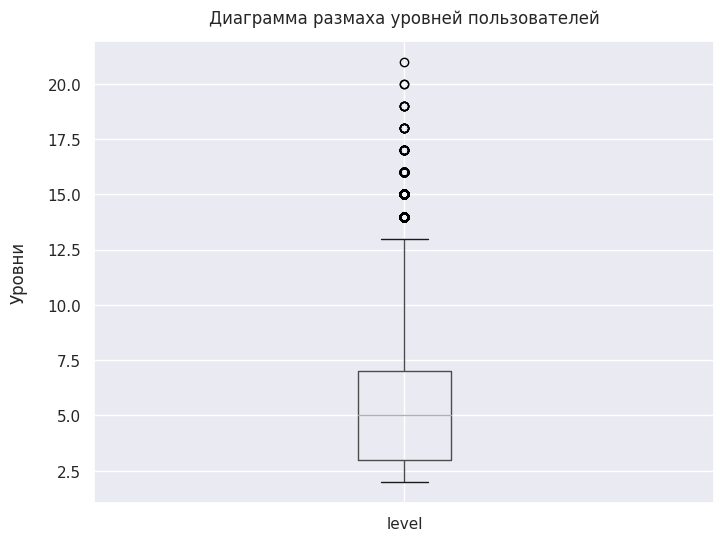

In [89]:
# диаграмма размаха
levels.boxplot('level')
plt.ylabel("Уровни", labelpad=14)
plt.title("Диаграмма размаха уровней пользователей", y=1.02);
plt.show()

Среднее и медианное значение почти совпадают и составляют - 5 уровней.

75% пользователей не поднялись выше 7 уровня.

После 17 уровня данные можно признать аномальными, обозначим их кодовым названием "Epic"


In [90]:
# доля epic-уровней среди всех уровней
len(levels.query('level >= 15')) / len(levels) * 100

0.21741959685507148

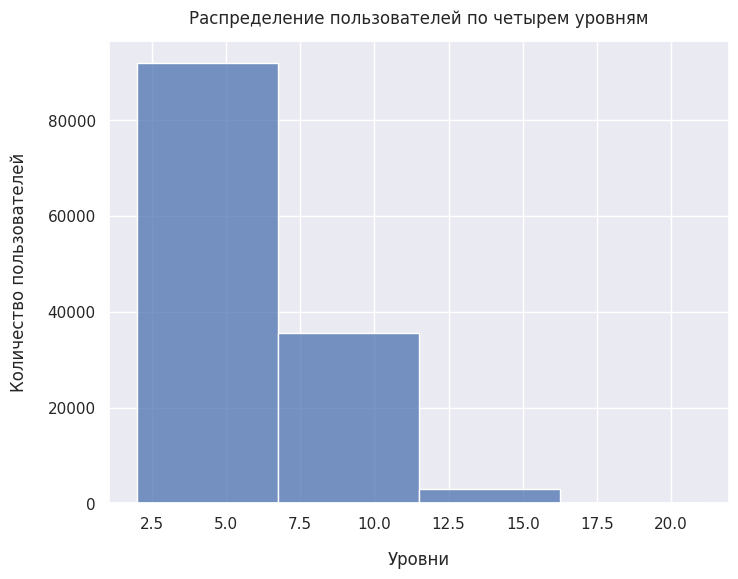

In [91]:
# распределение уровней игроков по 4 "корзинам"
fig, ax = plt.subplots()
sns.histplot(levels['level'], label='Game leveling', bins=4)
plt.xlabel("Уровни", labelpad=14)
plt.ylabel("Количество пользователей", labelpad=14)
plt.title("Распределение пользователей по четырем уровням", y=1.02);
plt.show()


Используя диаграмму распределения пользователей по уровням, можно сделать такую разбивку:
* Low: уровень 1-6
* Middle: уровень 7-11
* Hight: уровень 12-16
* Epic: уровень c 17 и выше


### Добавление новых столбцов

In [92]:
# добавление даты регистрации в таблицу users
users['dt'] = pd.to_datetime(users['reg_time']).dt.date

# добавление даты оплаты в таблицу payments
payments['dt_pay'] = pd.to_datetime(payments['pay_time']).dt.date

# добавление даты получения уровня в таблицу levels
levels['dt_lvl'] = pd.to_datetime(levels['time']).dt.date

In [93]:
# добавление время сессии в минутах в таблицу sessions
sessions['session_time_minutes'] = (sessions['close_time'] - sessions['open_time']).dt.total_seconds() / 60.0

Реализуем функцию разбивки числа очков уровня по уровню игры


In [94]:
# функция распределения игроков по уровню игры в зависимости от очков уровня
def game_level(level):
  if level <= 6:
    return 'Low'
  elif level > 16:
    return 'Epic'
  elif 6 < level <= 11:
    return 'Middle'
  elif 11 < level <= 16:
    return 'Hight'
  else:
    return 'no game'


# создание столбца с уровнем игры в таблице levels
levels['game_level'] = levels['level'].apply(game_level)

In [95]:
# количество раз, когда был получен тот или иной категориальный уровень игры
levels['game_level'].value_counts()

Low       91929
Middle    35678
Hight      2979
Epic         37
Name: game_level, dtype: int64

### Создание профилей пользователей

In [96]:
# функция для создания профилей, объединяющая все интересующие данные в одной таблице
def get_profiles(sessions, levels, users, how_merge='outer'):

    profiles = (
        sessions.sort_values(by=['user_id', 'open_time'])
        .groupby('user_id')
        .agg(
            {
                'open_time': 'first',

            }
        )
        .rename(columns={'open_time': 'first_session_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первой сессии

    profiles['first_session_dt'] = profiles['first_session_ts'].dt.date


    # объединяем таблицы с регистрацией и сессиями
    profiles = pd.merge(profiles , users , on=['user_id'], how='outer')
    profiles['reg_time_dt'] = profiles['reg_time'].dt.date




    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(payments['user_id'].unique())

    # для когортного анализа определяем дату последнего получения уровня
    # и сам последний уровень
    lvl = (
        levels.sort_values(by=['user_id', 'time'])
        .groupby('user_id')
        .agg(
            {
                'time': 'last',
                'level': 'last',
                'game_level': 'last'
            }
        )
        .rename(columns={
            'time': 'last_ts_lvl',
            'level': 'last_level_num',
            'game_level': 'last_game_level'
            }
            )
        .reset_index()
    )
    # объединение таблиц с уровнями
    profiles = pd.merge(lvl, profiles, on=['user_id'], how=how_merge)
    # номер недели регистрации
    #profiles['reg_week'] = profiles['reg_time'].dt.strftime('%U')

    avg_session_time = (
        sessions.groupby('user_id').agg({'session_time_minutes': 'mean'})
    ).rename(columns={'session_time_minutes': 'avg_time_minutes'})
    cnt_sessions = (
        sessions.groupby('user_id').agg({'open_time': 'count'})
    ).rename(columns={'open_time': 'cnt_sessions'})

    # добавим среднее время сесии
    profiles = pd.merge(profiles, avg_session_time , on=['user_id'], how=how_merge)
    # добавим количество сессий
    profiles = pd.merge(profiles, cnt_sessions , on=['user_id'], how=how_merge)

    # добавим общую сумму покупок
    total_amt  = (
        payments.groupby('user_id').agg({'amt': 'sum'}).rename(columns={'amt': 'total_amt'})
    )
    profiles = pd.merge(profiles , total_amt , on=['user_id'], how=how_merge)

    # добавим количество покупок
    count_amt  = (
        payments.groupby('user_id').agg({'amt': 'count'}).rename(columns={'amt': 'count_amt'})
    )
    profiles = pd.merge(profiles , count_amt , on=['user_id'], how=how_merge)

    # факт начала игры
    profiles['gamer'] = profiles['user_id'].isin(sessions['user_id'].unique())



    return profiles

In [97]:
# вызов функции для сбора интересующих данных о пользователях
profiles = get_profiles(sessions, levels, users)
# вывод первых 5 строк на экран
profiles.head()

,user_id,last_ts_lvl,last_level_num,last_game_level,first_session_ts,first_session_dt,reg_time,dt,reg_time_dt,payer,avg_time_minutes,cnt_sessions,total_amt,count_amt,gamer
0,58,2023-05-16 08:40:21,3.00,Low,2023-05-16 08:30:11,2023-05-16,2023-05-16 08:30:11,2023-05-16,2023-05-16,False,18.72,1.00,NaN,NaN,True
1,95,2023-05-16 21:14:37,2.00,Low,2023-05-16 21:12:02,2023-05-16,2023-05-16 21:12:02,2023-05-16,2023-05-16,False,4.13,1.00,NaN,NaN,True
2,109,2023-05-16 04:44:28,3.00,Low,2023-05-16 04:40:09,2023-05-16,2023-05-16 04:40:08,2023-05-16,2023-05-16,False,5.12,1.00,NaN,NaN,True
3,117,2023-05-16 11:02:28,2.00,Low,2023-05-16 10:58:31,2023-05-16,2023-05-16 10:58:30,2023-05-16,2023-05-16,False,2.66,2.00,NaN,NaN,True
4,187,2023-05-17 04:10:07,2.00,Low,2023-05-17 04:05:11,2023-05-17,2023-05-17 04:05:11,2023-05-17,2023-05-17,False,6.47,1.00,NaN,NaN,True


In [98]:
# информация о сборном датасете
profiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31114 entries, 0 to 31113
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           31114 non-null  int64         
 1   last_ts_lvl       25545 non-null  datetime64[ns]
 2   last_level_num    25545 non-null  float64       
 3   last_game_level   25545 non-null  object        
 4   first_session_ts  31070 non-null  datetime64[ns]
 5   first_session_dt  31070 non-null  object        
 6   reg_time          31114 non-null  datetime64[ns]
 7   dt                31114 non-null  object        
 8   reg_time_dt       31114 non-null  object        
 9   payer             31114 non-null  bool          
 10  avg_time_minutes  31070 non-null  float64       
 11  cnt_sessions      31070 non-null  float64       
 12  total_amt         312 non-null    float64       
 13  count_amt         312 non-null    float64       
 14  gamer             3111

Зарегистрировалось 31114 пользователя, игру начали  31070, из них 25545 получили хотя бы второй уровень, платящих пользователей только 312

In [99]:
# распределение последний полученных уровней
profiles['last_game_level'].value_counts()

Low       13458
Middle    10534
Hight      1531
Epic         22
Name: last_game_level, dtype: int64

Таким образом, в общей таблице профайлов присутствуют пропуски:
* количество зарегистрированных пользователей совпадает с общим размером датасета - 31 114
* количество пользователей, начавших сессии 31 070, 0.14% человека остановились после регистрации
* количество пользователей, получивших хотя бы первый уровень 25 545 (82%)
* распределение уровней среди тех, кто получил хотя бы один уровень: 53% на низком уровне (Low - не более 6 уровней),  41% достигли среднего уровня (Middle от 7 до 11 уровней), 6% на высоком уровне (Hight от 12 до 16 уровней) и 0,09% (22 пользователя) достигли "эпического" уровня (Epic - выше 17 уровней)
* количество пользователей, совершивших платежи, 1% от все зарегистрировавшихся и 1,2% от тех, кто получил хотя бы один уровень

## Метрики вовлечённости

#### Активация в приложении
В любой игре пользователя сначала обучают, проводя его через туториал. Те, кто не прошли туториал, скорее всего, не будут дальше играть и тем более платить. Именно поэтому для нас критично отслеживать долю пользователей, успешно прошедших этот этап.

У нас 31114 зарегистрированных пользователя, но не все из них приступили к игре-обучению


In [100]:
# подсчет количества игроков и не начавших игру
data_gamer = profiles['gamer'].value_counts().reset_index()
# создание столбца  is_chain со значением по умолчанию 'Сетевые'
data_gamer['is_gamer'] = 'Не игрок'
# переименование столбцов
data_gamer.columns=['index', 'gamer', 'is_gamer']
# замена по индексу значений на 'Не игрок'
data_gamer.iloc[0,2] = 'Игрок'
data_gamer['perc'] = round(data_gamer['gamer'] / sum(data_gamer['gamer']) * 100, 2)
data_gamer

,index,gamer,is_gamer,perc
0,True,31070,Игрок,99.86
1,False,44,Не игрок,0.14


In [101]:
# построение круговой диаграммы 'Соотношение сетевых и несетевых заведений'
fig = go.Figure(data=[go.Pie(labels=data_gamer['is_gamer'], # указываем значения, которые появятся на метках сегментов
                             values=data_gamer['perc'], # указываем данные, которые отобразятся на графике
                             textinfo='label+percent',
                             pull = [0.1, 0])]) # добавляем аргумент, который выделит сегмент-лидер на графике
fig.update_layout(title='Соотношение пользователей по факту начала игры', # указываем заголовок графика
                  width=800, # указываем размеры графика
                  height=600,
                  showlegend=False)

fig.show() # выводим график

Таким образом, после регистрации "потерялось" 44 пользователя. Хотя это значение менее 1%, стоит отправить им напоминания

#### Факт "залипания" в приложении (stickiness rate)
Пользователь, скорее всего, не будет платить, если он не увлекся игрой. Именно поэтому нам надо отслеживать долю тех, кто залип в приложении. С этой целью мы измеряем долю тех, кто прошел до N уровня.

Но для начала найдем общую метрику (general usage stickiness): сколько дней из недели или месяца пользователи делали что-либо в нашем продукте.

In [102]:
# отберем только тех, кто начал игру, данные о таких пользователях возьмем из таблицы sessions
sessions['session_week'] = (
    sessions['open_time'].dt.isocalendar().week
)
sessions['session_date'] = sessions['open_time'].dt.date
sessions['session_month'] = sessions['open_time'].dt.month

# mau — количество уникальных пользователей в месяц
mau_total = (
    sessions.groupby(['session_month'])
    .agg({'user_id': 'nunique'})
    .mean()
)
# dau -  количество уникальных пользователей в день
dau_total = (
    sessions.groupby('session_date')
    .agg({'user_id': 'nunique'})
    .mean()
)

# wau - количество уникальных пользователей в неделю
wau_total = (
    sessions.groupby(['session_month', 'session_week'])
    .agg({'user_id': 'nunique'})
    .mean()
)
sticky_wau = dau_total / wau_total * 100
print(f'Недельная аудитория {sticky_wau}')
sticky_mau = dau_total / mau_total * 100
print(f'Аудитория за месяц {sticky_mau}')

Недельная аудитория user_id   49.09
dtype: float64
Аудитория за месяц user_id   16.45
dtype: float64


Таким образом, регулярность использования приложения недельной аудиторией составляет 49.09%, для месячной аудитории (всего предоставленного периода данных) - 16.45 %

Метрики DAU, WAU и MAU малочувствительны к изменениям в продукте, поэтому не помогут определить, стоит ли запускать в приложении новые функции или принять другое бизнес-решение. Как правило, эти метрики постоянно растут, поэтому служат хорошей мотивацией для команды. На английском их называют vanity metrics, то есть «метрики тщеславия»

In [103]:
# отберем пользователей, начавших игру - их Id есть в таблице sessions
data_gamer = profiles.query('gamer == True')


In [104]:
# заполним пропуски, если о пользователе отсутствовала информация в levels, но есть сессии sessions, значит, он на начальном уровне

# дополняем категории уровней новой - 'No lvl up'
data_gamer['last_game_level'] = data_gamer['last_game_level'].fillna('No lvl up')
# всем не апнувшимся присвоим первый уровень
data_gamer['last_level_num'] = data_gamer['last_level_num'].fillna('1')

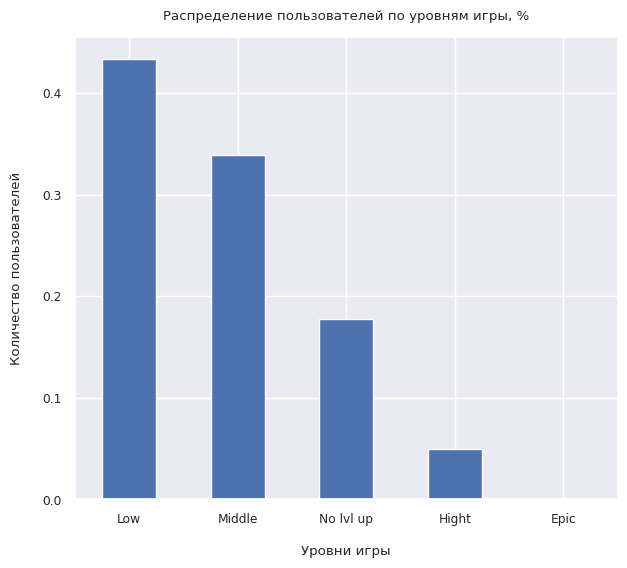

In [105]:
# распределение пользователей по уровням игры
sns.set(font_scale=0.8)
data_gamer['last_game_level'].value_counts(normalize=True).plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Уровни игры", labelpad=14)
plt.ylabel("Количество пользователей", labelpad=14)
plt.title("Распределение пользователей по уровням игры, %", y=1.02);

Основная часть пользователей (примерно 42%) имеют низкий уровень игры (их уровень не превышает 6), примерно 34% достигли среднего уровня (от 7 до 11), на высоком и эпическом уровне играют около 5%.
Главная находка - примерно 18% игроков не перешли на второй уровень, хотя и начинали игру (первый уровень у всех по умолчанию)

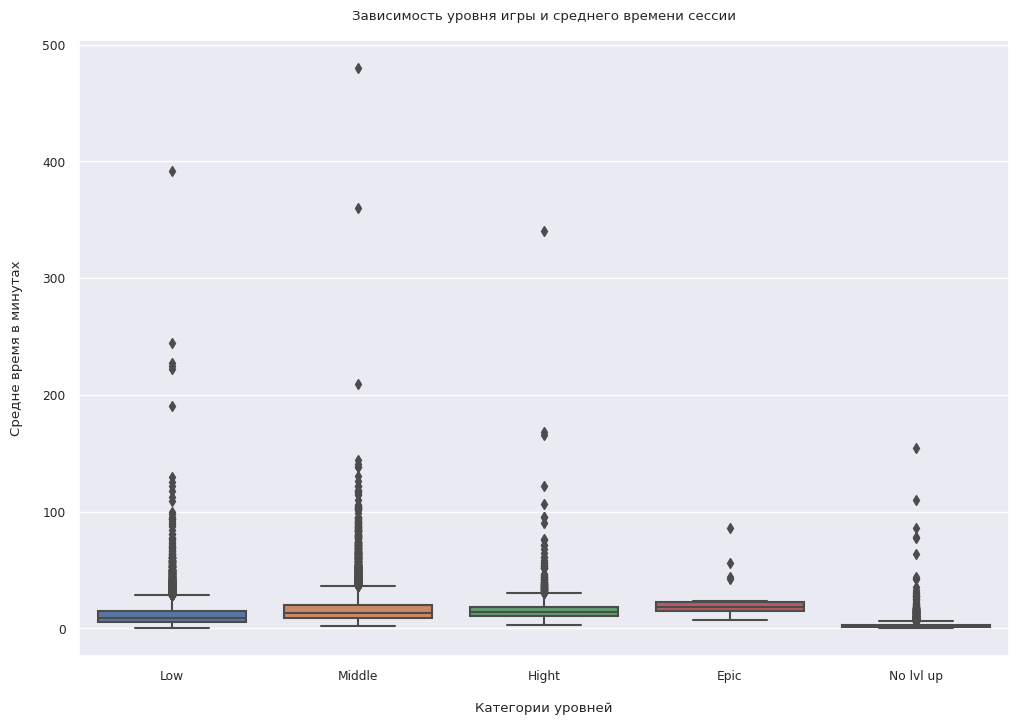

In [106]:
# зависимость уровня игры и среднего времени сессии
plt.figure(figsize=(12,8))
sns.boxplot(data=data_gamer, x="last_game_level", y="avg_time_minutes")
plt.xlabel("Категории уровней", labelpad=14)
plt.ylabel("Средне время в минутах", labelpad=14)
plt.title("Зависимость уровня игры и среднего времени сессии", y=1.02);
plt.show()

По данным диаграммам размаха очень сложно сделать какие-либо выводы из-за большого количества выбросов. Добавим ограничение по оси у

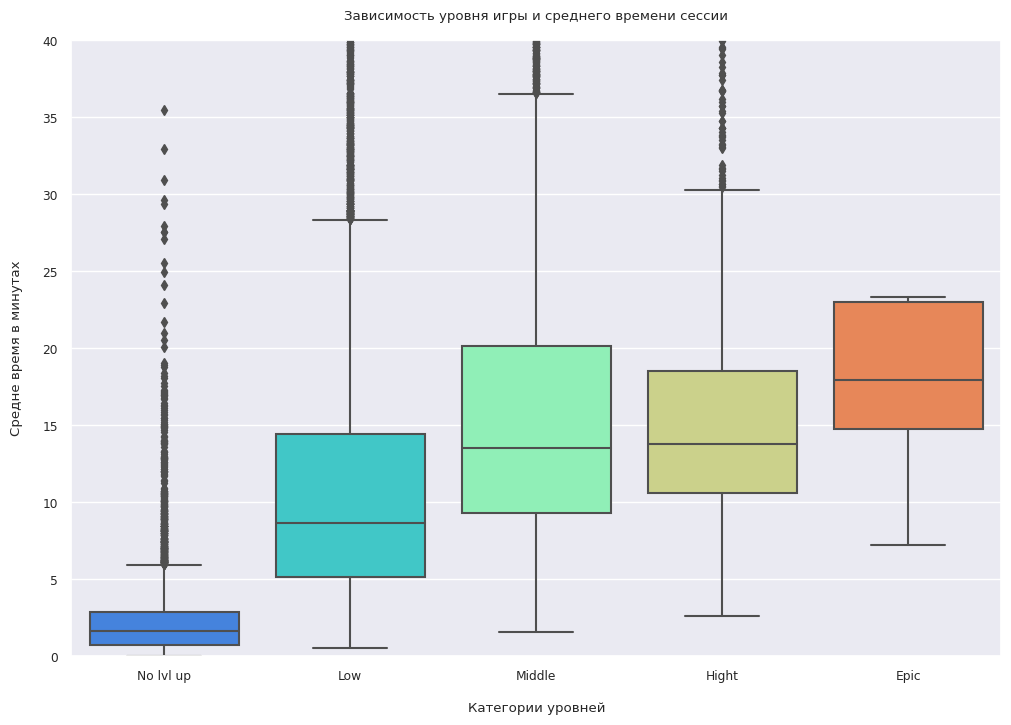

In [107]:
# зависимость уровня игры и среднего времени сессии
plt.figure(figsize=(12,8))
# для сортировки по медиане
grouped = data_gamer.loc[:,['last_game_level', 'avg_time_minutes']] \
    .groupby(['last_game_level']) \
    .median() \
    .sort_values(by='avg_time_minutes')

sns.boxplot(data=data_gamer, x="last_game_level", y="avg_time_minutes", palette='rainbow', order=grouped.index)
plt.xlabel("Категории уровней", labelpad=14)
plt.ylabel("Средне время в минутах", labelpad=14)
plt.title("Зависимость уровня игры и среднего времени сессии", y=1.02);
ax = plt.gca()
ax.set_ylim([0, 40])
plt.show()


Видно, что наименьщее время игры у тех, кто только зашел в приложение. Игроки среднего и высокого уровня проводят в приложении примерно одинаковое количество времени

Изучим дополнительные возможные зависимости между числовыми данными

In [108]:
# корреляция между средним временем сессии и количеством сессий
data_gamer['avg_time_minutes'].corr(data_gamer['cnt_sessions'])

0.022124083759667873

Зависимости между средним временем сессии и количеством сессий нет: корреляция 2,2%

In [109]:
# корреляция между средним временем сессии и покупками
data_gamer['avg_time_minutes'].corr(data_gamer['total_amt'])

0.4629762003405758

Наблюдается слабая связь между средним временем сесии и покупками в приложении: коэффициент корреляции 46,2%. Есть вероятность, что чем дольше пользователь проводит времени в приложении, тем вероятнее он сделает покупку

In [110]:
# корреляция между покупками и  количеством сессий
data_gamer['cnt_sessions'].corr(data_gamer['total_amt'])

-0.02331956506823772

Между совершением покупки и количеством сессии скорее всего никакой связи нет

In [111]:
data_gamer['last_level_num'] = data_gamer['last_level_num'].astype('int64')
# корреляция между уровнем  и количеством сессий
data_gamer['last_level_num'].corr(data_gamer['cnt_sessions'])

0.7241416392999486

Единственными хорошо коррелирующими переменными (корреляция 72%) являются уровень и количество сессии. Это логично: чем больше сессиий (времени) тратит пользователь, тем выше становится его уровень

В данных очень много выбросов. Сравним среднее и медианное значение для игроков, достигших определенного уровня


In [112]:
data_gamer.groupby('last_game_level').agg({'avg_time_minutes': ['mean','median'], 'cnt_sessions': ['mean', 'median']})

avg_time_minutes        cnt_sessions       
                            mean median         mean median
last_game_level                                            
Epic                       24.24  17.95       118.09 128.50
Hight                      16.49  13.79        72.35  68.00
Low                        11.52   8.63         2.25   1.00
Middle                     16.94  13.55        19.74  13.00
No lvl up                   2.44   1.65         1.16   1.00

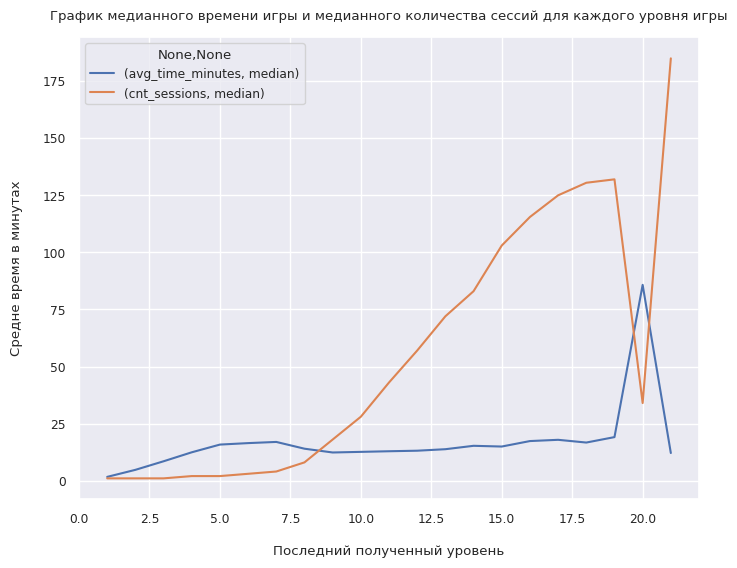

In [113]:
# график медианного времени игры и медианного количества сессий для каждого уровня игры
data_gamer.groupby('last_level_num').agg({'avg_time_minutes': ['median'], 'cnt_sessions': ['median']}).plot()
plt.xlabel("Последний полученный уровень", labelpad=14)
plt.ylabel("Средне время в минутах", labelpad=14)
plt.title("График медианного времени игры и медианного количества сессий для каждого уровня игры", y=1.02);

Табличные значения выглядят вполне логичено: чем выше уровень, тем больше медианное время сессии и количество сессий, кроме 20 уровня: среднее сремя сессии в 5,5 раз больше среднего на каждой уровне, а количество сессий резко меньше (это возможно объяснить тем, что пользователи целенаправленно долго проходили игру, затрачивая на каждую сессию большее количество времени, чем обычно)

Посмотрим на игроков 20 уровня. Такой игрок у нас один

In [114]:
# аномальный игрок
data_gamer.query('last_level_num == 20')

,user_id,last_ts_lvl,last_level_num,last_game_level,first_session_ts,first_session_dt,reg_time,dt,reg_time_dt,payer,avg_time_minutes,cnt_sessions,total_amt,count_amt,gamer
23811,931233,2023-05-30 15:35:11,20,Epic,2023-05-21 01:13:21,2023-05-21,2023-05-21 01:13:20,2023-05-21,2023-05-21,True,85.78,34.00,13.02,18.00,True


In [115]:
# время игры аномального игрока по дням
sessions.query('user_id == 931233').groupby('session_date').agg({'session_time_minutes': 'sum'}).rename(columns={'session_time_minutes':'total_time_min'})

,total_time_min
session_date,
2023-05-21,235.75
2023-05-22,600.93
2023-05-23,92.17
2023-05-24,568.50
2023-05-25,564.27
2023-05-26,80.30
2023-05-28,121.10
2023-05-29,341.70
2023-05-30,311.87


Это  уникальный пользователь, который с 21 по 30 мая играл от 1ч.20 минут до 10 часов в день!

In [116]:
# как аномальный игрок получал уровни
levels.query('user_id == 931233')

,user_id,time,level,dt_lvl,game_level
70660,931233,2023-05-21 01:16:35,2.00,2023-05-21,Low
70661,931233,2023-05-21 01:19:21,3.00,2023-05-21,Low
70662,931233,2023-05-21 01:23:48,4.00,2023-05-21,Low
70663,931233,2023-05-21 01:38:49,5.00,2023-05-21,Low
70664,931233,2023-05-21 18:51:46,6.00,2023-05-21,Low
70665,931233,2023-05-21 19:04:31,7.00,2023-05-21,Middle
70666,931233,2023-05-21 19:23:34,8.00,2023-05-21,Middle
70667,931233,2023-05-21 21:12:44,9.00,2023-05-21,Middle
70668,931233,2023-05-21 22:08:50,10.00,2023-05-21,Middle
70669,931233,2023-05-22 18:23:16,11.00,2023-05-22,Middle


In [117]:
# сколько длилась сессия у аномального игрока
sessions.query('user_id == 931233')

,user_id,close_time,open_time,session_time_minutes,session_week,session_date,session_month
85478,931233,2023-05-21 01:44:45,2023-05-21 01:13:21,31.40,20,2023-05-21,5
85479,931233,2023-05-21 22:09:48,2023-05-21 18:45:27,204.35,20,2023-05-21,5
85480,931233,2023-05-23 02:35:03,2023-05-22 16:34:07,600.93,21,2023-05-22,5
85481,931233,2023-05-23 14:47:18,2023-05-23 14:25:55,21.38,21,2023-05-23,5
85482,931233,2023-05-23 16:55:35,2023-05-23 16:20:12,35.38,21,2023-05-23,5
85483,931233,2023-05-23 17:59:51,2023-05-23 17:24:27,35.40,21,2023-05-23,5
85484,931233,2023-05-24 03:14:10,2023-05-24 00:26:57,167.22,21,2023-05-24,5
85485,931233,2023-05-24 04:22:33,2023-05-24 03:36:55,45.63,21,2023-05-24,5
85486,931233,2023-05-24 06:20:08,2023-05-24 06:11:44,8.40,21,2023-05-24,5
85487,931233,2023-05-24 12:53:12,2023-05-24 12:40:57,12.25,21,2023-05-24,5


* 2-5 уровень 31,4 минуты
* 6-10 уровень 204,35 минуты
* с 10 по 15 600,93 минуты
* На 16 уровень ушло 35 минут
* На 17 уровне 212 минут
* Через три дня игры перешел на 18 уровень и т.д.

В целом, нельзя сказать, почему данный пользователь проходил в среднем уровни дольше, чем другие. Возможно, потому что играл ночью, возможно, отвлекался на другие дела. Но этого пользователя, как аномального, стоит исключить из дальнейшего анализа, хотя бы из stickiness rate

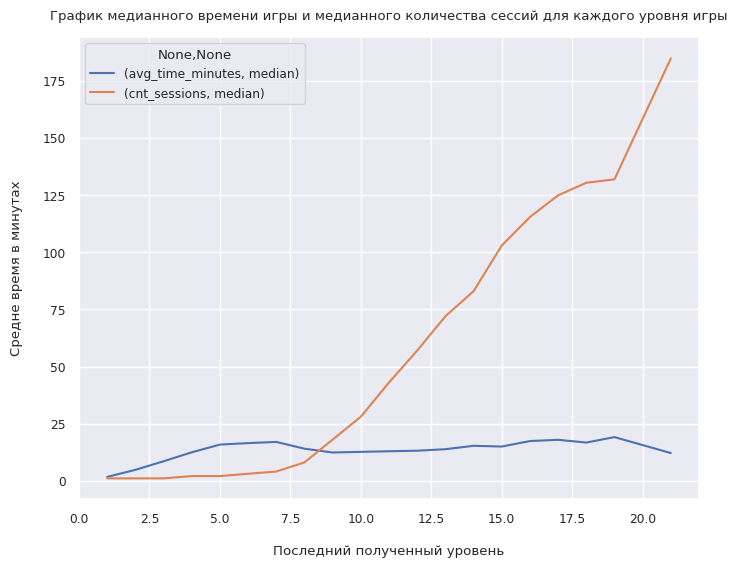

In [118]:
# исключение аномального по времени игры пользователя
data_gamer = data_gamer.query('user_id != 931233')
data_gamer.groupby('last_level_num').agg({'avg_time_minutes': ['median'], 'cnt_sessions': ['median']}).plot()
plt.xlabel("Последний полученный уровень", labelpad=14)
plt.ylabel("Средне время в минутах", labelpad=14)
plt.title("График медианного времени игры и медианного количества сессий для каждого уровня игры", y=1.02);

In [119]:
data_gamer.groupby('last_level_num').agg({'avg_time_minutes': ['median'], 'cnt_sessions': ['median']})

,avg_time_minutes,cnt_sessions
,median,median
last_level_num,,
1,1.65,1.00
2,4.73,1.00
3,8.48,1.00
4,12.42,2.00
5,15.80,2.00
6,16.44,3.00
7,16.96,4.00
8,14.00,8.00


Теперь кривая времени, проведенного в приложении, выглядит лучше: медианное время на каждом уровне не превышает 20 минут, но при этом  уровни 6, 7 по временным затратам сравнимы с уровнем 18

Вывод:
* Пользователи, не получившие даже первого уровня, в среднем проводят в приложении <b>одну двухминутную сессию</b> (зашли, посмотрели контент, не заинтересовало - вышли и больше не вернулись) - и таких 18%!
* Пользователи уровня Low проводят 1-2 сессии около 8-9 минут - проходят игру чуть дальше и на каком-то моменте теряют интерес
* Пользователи среднего уровня Middle в среднем имеют 19 сессий (13 по медиане) и заинтересованы в приложении - проводят там от 14-16 минут
* Пользователи высокого уровня Hight в среднем достигали его за 68-72 сессии, среднее время сессии  14-16 минут
* Пользователи эпического уровня (таких всего 37) в среднем имеют по 118-128 сессий со средним временем 18-24 минуты

Значит, чтобы пользователь удерживался в приложении, он должен потратить 14-16 минут за сессии для успешного обучения-прохождения контента

#### Retention Rate
Retention Rate, или коэффициент удержания, показывает, как долго клиенты остаются в приложении. Это один из важнейших показателей «здоровья» бизнеса.

Для того чтобы пользователи имели шанс совершить несколько покупок, они должны продолжать играть в нашу игру в течение длительного времени, а не бросать ее спустя день. Для отслеживания этого явления мы будем измерять Retention.

In [120]:
# присоединяем session.open_time к профилям по столбцу user_id
result_raw = profiles.merge(
    sessions[['user_id', 'open_time']], on='user_id', how='left'
)


Оказалось, что для некоторых пользователей время начала сессии было до момента регистрации. Возможно, познакомиться с приложением можно без регистрации, но для сохранения уровня - необходимо ее пройти.
Выразим отрицательные значения через модуль

In [121]:
# вычисляем лайфтайм каждой сессии в днях
result_raw['lifetime'] = abs((
    result_raw['open_time'] - result_raw['reg_time']
).dt.days)


In [122]:
result_raw['lifetime'].value_counts()

0.00    92413
1.00    44890
2.00    37172
3.00    33180
4.00    30025
5.00    27527
6.00    26730
7.00    26172
8.00    24891
9.00    15004
Name: lifetime, dtype: int64

In [123]:
# строим таблицу удержания

result_grouped = result_raw.pivot_table(
    index=['lifetime'], values='user_id', aggfunc='nunique'
)
result_grouped.columns = ['total_user']
result_grouped['retention_rate'] = result_grouped['total_user'] / result_grouped['total_user'][0]

result_grouped = result_grouped.T
result_grouped = result_grouped.drop(columns=[0])
result_grouped

lifetime,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00
total_user,"11,153.00","9,045.00","7,946.00","7,149.00","6,639.00","6,275.00","5,988.00","5,646.00","4,695.00"
retention_rate,0.36,0.29,0.26,0.23,0.21,0.20,0.19,0.18,0.15


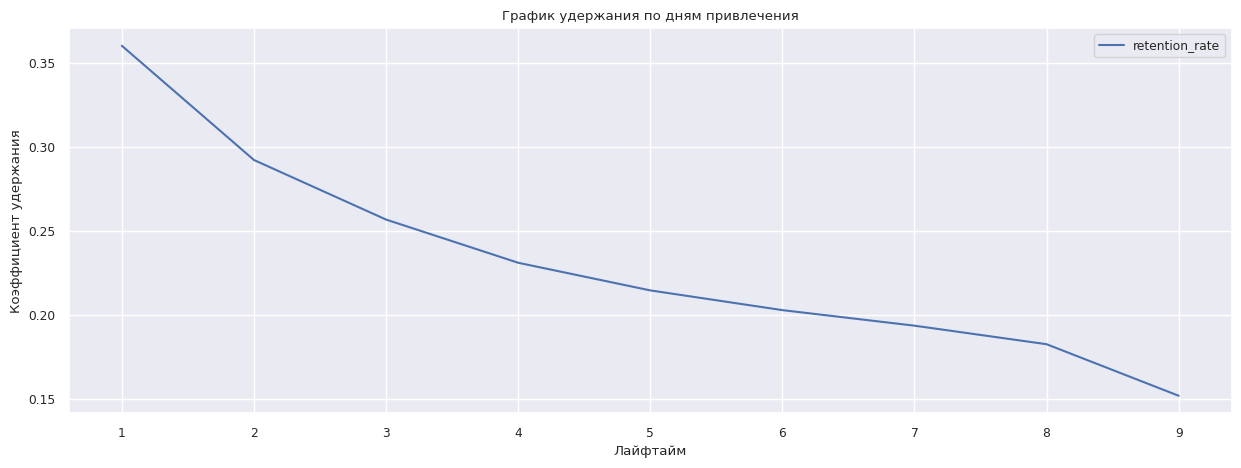

In [124]:
# строим кривые удержания
result_grouped.T.plot(
    grid=True,  # добавляем сетку
    y='retention_rate',
    figsize=(15, 5),  # размер графика
)
plt.xlabel('Лайфтайм')  # название оси X
plt.ylabel('Коэффициент удержания')  # название оси X
plt.title('График удержания по дням привлечения')  # название графика
plt.show()

In [125]:
# рассчитываем удержание с  ['payer']

result_grouped_payer = result_raw.pivot_table(
    index=['payer'],  # заменили dt
    columns='lifetime',
    values='user_id',
    aggfunc='nunique',
        )


result_grouped_payer = result_grouped_payer.T
result_grouped_payer.columns = ['False', 'True']
result_grouped_payer['RR_False'] = result_grouped_payer['False'] / result_grouped_payer['False'][0]
result_grouped_payer['RR_True'] = result_grouped_payer['True'] / result_grouped_payer['True'][0]
result_grouped_payer = result_grouped_payer.T
result_grouped_payer

lifetime,0.00,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00
False,"30,641.00","10,903.00","8,823.00","7,735.00","6,945.00","6,440.00","6,091.00","5,811.00","5,489.00","4,561.00"
True,312.00,250.00,222.00,211.00,204.00,199.00,184.00,177.00,157.00,134.00
RR_False,1.00,0.36,0.29,0.25,0.23,0.21,0.20,0.19,0.18,0.15
RR_True,1.00,0.80,0.71,0.68,0.65,0.64,0.59,0.57,0.50,0.43


In [126]:
# удалим значение первого дня, которое всегда равно 1
report = result_grouped_payer.drop(columns=[0])
report = report.T
# оставляем только значение коэффициентов
report = report.drop(columns=['False', 'True'])


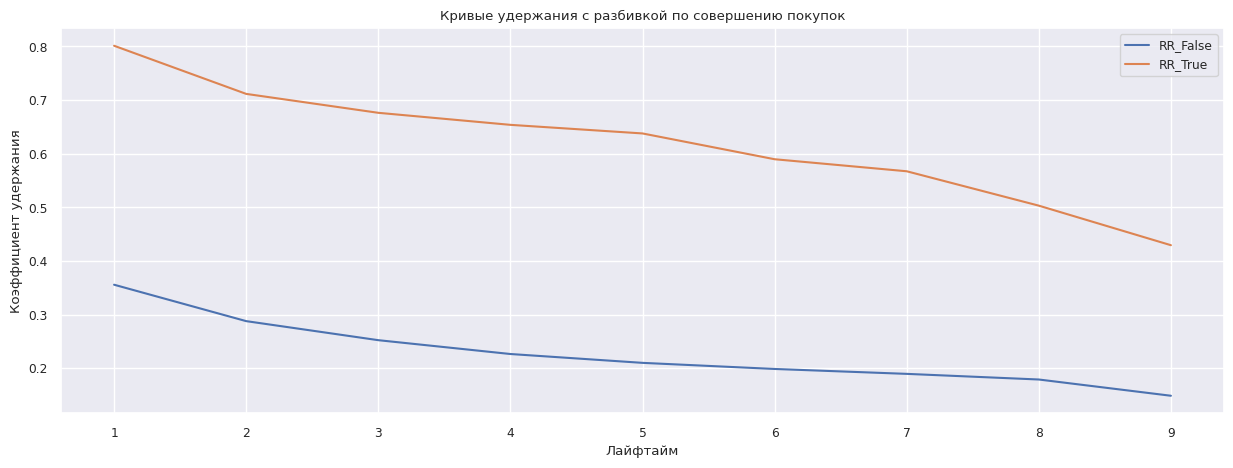

In [127]:
# строим кривые удержания

report.plot(
    grid=True,  # добавляем сетку

    figsize=(15, 5),  # размер графика
)
plt.xlabel('Лайфтайм')  # название оси X
plt.ylabel('Коэффициент удержания')  # название оси X
plt.title('Кривые удержания с разбивкой по совершению покупок')  # название графика
plt.show()

Удержание платящих значительно выше удержания неплатящих. Так бывает почти всегда, поэтому разбивка пользователей на платящих и неплатящих — стандартная практика.

## Метрики монетизации

#### ARPU (Average Revenue Per User)
ARPU — метрика, которая показывает, насколько высока ценность продукта в глазах пользователей — сколько они готовы заплатить за продукт.

In [128]:
sum(payments['amt']) / len(users)

0.01611513630986176

Суммарная выручка приложения примерно 500 денежных единиц, метрика ARPU = 0,016 - столько клиент в среднем платит в месяц за наше приложение.
ARPU помогает корректировать рекламные кампании, искать узкие места в продукте (интернет-магазине) и находить точки роста, которые помогают увеличивать другие ключевые метрики, такие как конверсия и выручка

#### ARPPU (Average Revenue Per Paying User)
ARPPU – это реакция именно платящих пользователей на ценность, которую несёт наш проект. Эта метрика показывает, сколько готов заплатить лояльный платящий пользователь. Также ее можно трактовать как реакцию пользователей на цены, установленные в проекте.

In [129]:
sum(payments['amt']) / payments['user_id'].nunique()

1.6070716382853807

#### AOV (Average order value)
Средний чек. Рассчитывается как общий доход, поделенный на количество покупок.

In [130]:
sum(payments['amt'])/len(payments)

0.7173195295351056

#### Процент платящих пользователей

Одной из наших целей является получение дохода, поэтому нам надо стимулировать первую покупку в приложении. Но покупка совершается с определенного экрана нашего приложения (например, с экрана магазина), поэтому необходимо отслеживать долю пользователей, которые увидели этот экран.
Если экран о продаже видят 10% приходящих пользователей, то это автоматически ограничивает сверху долю пользователей, которые могут сделать первую покупку в нашей игре.

У нас всего 311 платящих пользователей. Изучим, как они совершали свои покупки

In [131]:
len(data_gamer.query('payer == True'))

311

In [132]:
len(data_gamer.query('payer == True')) / len(profiles) * 100

0.9995500417818345

Только 1% пользователей приложения сделали покупки

#### Процент повторных покупок

Первая покупка — это хорошо, но финансово успешные продукты обычно отличаются высокой долей повторных покупок. Часто первая покупка — это определенный кредит доверия пользователя приложению: если он удовлетворен результатом и полученной пользой, то, скорее всего, он совершит и повторную покупку. Поэтому еще одной важной метрикой становится, доля пользователей, совершающих повторные покупки, а также среднее количество повторных покупок.

In [133]:
len(data_gamer.query('count_amt > 1')) / len(data_gamer.query('payer == True')) * 100

36.655948553054664

Тем не менее, почти 37% пользователей, сделавших покупку, купили что-то в приложении два и более раз

#### Как пользователи совершали покупки
* средний размер каждого платежа
* связь первого платежа и уровня


In [134]:
# добавление информации, на каком уровне был пользователь, когда совершил платеж
def pay_on_lvl(row):
  # вытаскиваем из строки user_id
  user_id = row['user_id']
  # вытаскиваем из строки pay_time
  pay_time = row['pay_time']
  # отбираем из таблицы уровней информацию по конкретному пользователю
  data=levels.query('user_id ==@user_id')
  # переворачиваем, так чтобы самая поздняя дата получения уровня оказалась первой
  data = data[::-1]
  # фильтруем данные
  filter = data['time'] < pay_time
  # оставляем только True значения
  filter = filter[filter]
  try:
      # если есть хотя бы одно True, возвращаем первое значение списка
      id_last_lvl = filter.index.tolist()[0]
  except:
    # иначе возвращаем первый уровень
    return 1


  return data.loc[id_last_lvl, 'level']

payments['pay_on_lvl'] = payments.apply(pay_on_lvl, axis=1)


In [135]:
# вывод обновленной информации с добавлением уровня, на котором была совершена покупка
payments.head()

,user_id,pay_time,amt,dt_pay,pay_on_lvl
0,107907,2023-05-29 17:08:18,0.40,2023-05-29,9.00
1,510991,2023-05-20 16:55:01,0.20,2023-05-20,7.00
2,294837,2023-05-19 01:41:55,0.20,2023-05-19,6.00
3,644287,2023-05-20 03:01:53,0.20,2023-05-20,7.00
4,673424,2023-05-20 03:33:36,0.10,2023-05-20,8.00


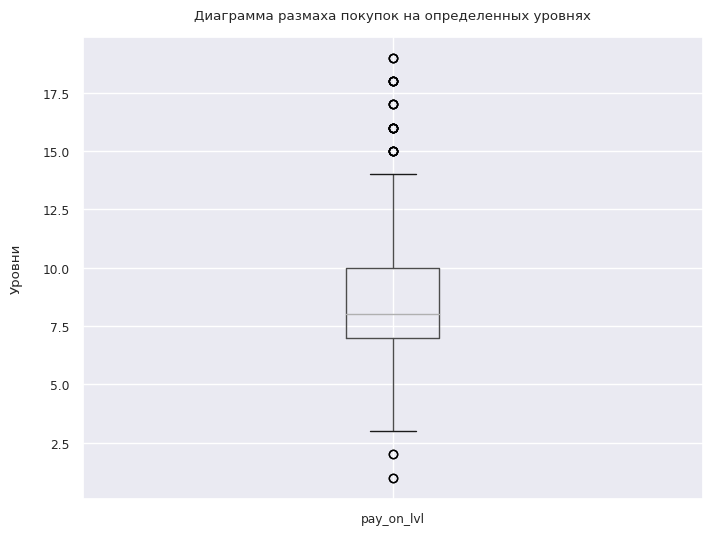

In [136]:
# диаграмма размаха покупок на определенных уровнях
payments.boxplot('pay_on_lvl')
plt.ylabel("Уровни", labelpad=14)
plt.title("Диаграмма размаха покупок на определенных уровнях", y=1.02);
plt.show()

По диаграмме видно, что до второго у нас явно есть аномалии

In [137]:
# платежи до второго уровня
payments.query('pay_on_lvl < 2')

,user_id,pay_time,amt,dt_pay,pay_on_lvl
252,759639,2023-05-15 16:12:06,10.03,2023-05-15,1.00
253,759639,2023-05-15 16:12:26,10.03,2023-05-15,1.00


По данным видно, что прошли два одинаковых платежа почти в одно и то же время, возможно, это была ошибка. Но при среднем значении платежа в 0,7 для всех пользователей и в 1,6 только среди платящих, эти данные выглядят очень завышено.
Предлагается удалить эти данные из дальнешего анализа

In [138]:
payments = payments.query('pay_on_lvl >= 2')

In [139]:
# распределение общих и средних сумм покупок, а также количество пользователей, которые совершили покупки, по уроням
payments.groupby('pay_on_lvl').agg({'amt': ['sum', 'mean'], 'user_id': 'count'})

amt      user_id
              sum mean   count
pay_on_lvl                    
2.00         3.41 1.70       2
3.00         5.41 0.68       8
4.00        31.55 0.70      45
5.00        16.29 0.26      62
6.00        12.11 0.61      20
7.00        17.11 0.36      47
8.00       127.11 0.73     173
9.00        82.73 0.70     119
10.00       64.01 0.76      84
11.00       40.67 0.83      49
12.00       34.57 0.96      36
13.00        7.61 0.63      12
14.00       17.54 1.25      14
15.00        4.11 0.68       6
16.00        6.51 0.93       7
17.00        1.60 0.40       4
18.00        7.82 1.30       6
19.00        1.20 0.40       3

Наибольшее число покупок (173) и максимальная сумма (127.11) покупок была сделана пользователями на 8 уровне, максимальная средняя стоимость покупки на 2 уровне.

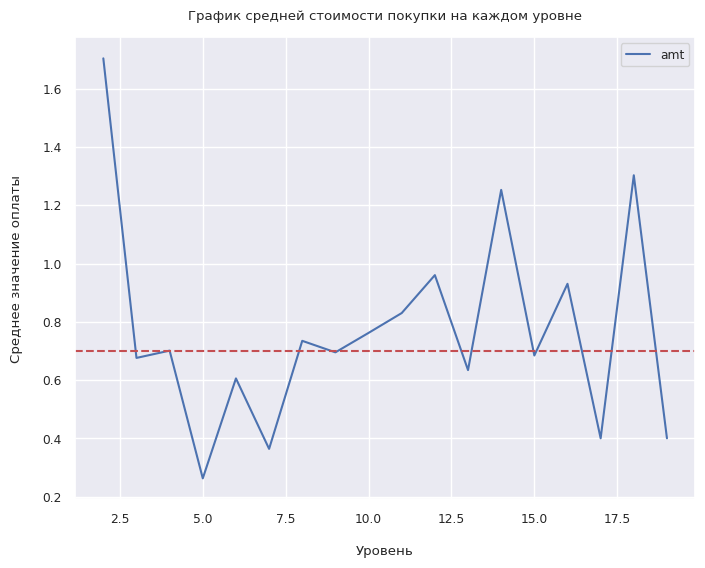

In [140]:
# график средней стоимости покупок на каждом уровне
payments.groupby('pay_on_lvl').agg({'amt': 'mean'}).plot()
plt.axhline(y=0.7, color='r', linestyle='--') # линия по среднему значению amt
plt.ylabel("Среднее значение оплаты", labelpad=14)
plt.xlabel("Уровень", labelpad=14)
plt.title("График средней стоимости покупки на каждом уровне", y=1.02);
plt.show()
plt.show()

Какой-то зависимости средней стоимости покупки и уровня нет. Разработчикам стоит обдумать этот момент, почему на разных уровнях получается разная ценовая политика. Что покупают пользователи? Как это помогает проходить им уровни?

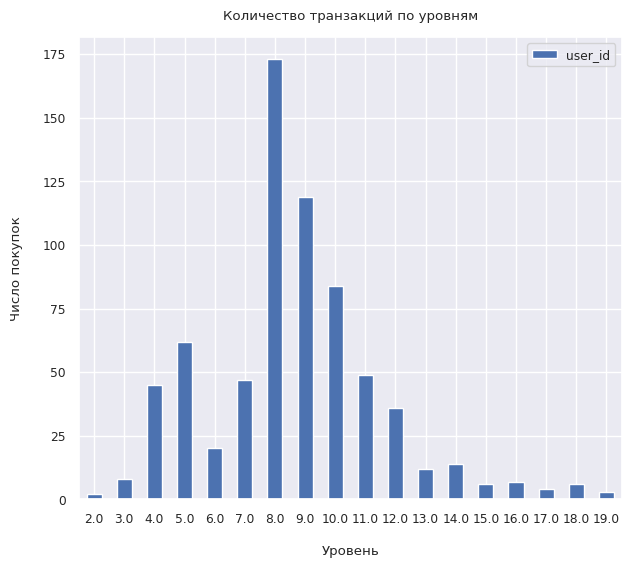

In [141]:
# количество платежей в зависимости от уровня
payments.groupby('pay_on_lvl').agg({'user_id': 'count'}).plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Число покупок", labelpad=14)
plt.xlabel("Уровень", labelpad=14)
plt.title("Количество транзакций по уровням", y=1.02);
plt.show()


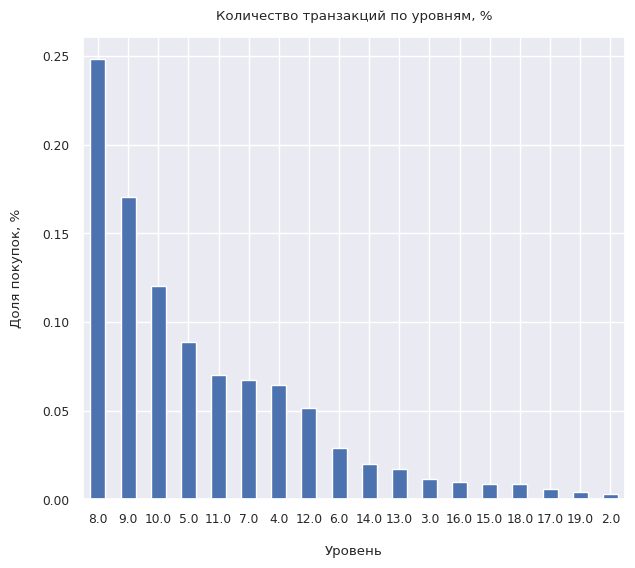

In [142]:
payments['pay_on_lvl'].value_counts(normalize=True).plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Доля покупок, %", labelpad=14)
plt.xlabel("Уровень", labelpad=14)
plt.title("Количество транзакций по уровням, %", y=1.02);
plt.show()

Почти 25% покупок было совершено на 8 уровне (наибольшее значение), также в тройке лидеров 9 и 10 уровень, наименьшее количество на 2, 17 и 19 уровнях

#### Анализ второй и следующих покупок


In [143]:
# проранжируем номера покупок
payments['row_number_by_group']=payments.groupby(['user_id'])['amt'].cumcount()+1
payments.tail()

,user_id,pay_time,amt,dt_pay,pay_on_lvl,row_number_by_group
694,722621,2023-05-27 19:13:39,0.40,2023-05-27,12.00,3
695,940244,2023-05-19 03:08:36,0.40,2023-05-19,4.00,1
696,895621,2023-05-22 20:50:28,3.01,2023-05-22,4.00,1
697,940244,2023-05-23 15:52:14,1.50,2023-05-23,8.00,2
698,403762,2023-05-18 11:35:46,0.20,2023-05-18,5.00,1


In [144]:
# Количество покупок и количество пользователей, совершивших столько покупой
payments['row_number_by_group'].value_counts()

1     312
2     115
3      70
4      46
5      33
6      21
7      17
8      13
9      11
10      9
11      8
12      8
13      7
14      6
15      6
16      4
17      3
18      2
19      1
20      1
21      1
22      1
23      1
24      1
Name: row_number_by_group, dtype: int64

In [145]:
payments['row_number_by_group'].describe()

count   697.00
mean      3.40
std       3.84
min       1.00
25%       1.00
50%       2.00
75%       4.00
max      24.00
Name: row_number_by_group, dtype: float64

Минимальное количество покупок - 1, максимальное количество покупок - 24, в среднем пользователи делали 3 покупки, по медиане - 2, 75% платящих пользователей не покупали больше четырёх раз

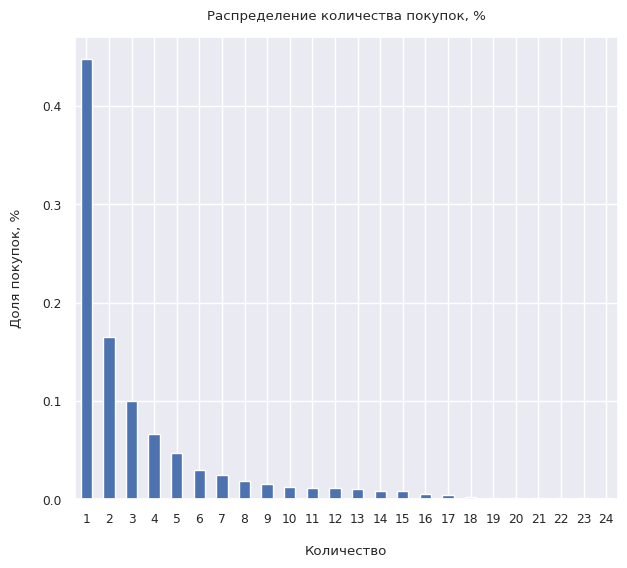

In [146]:
# распределение количества покупок и количества пользователей, сделавших такое количество покупок
payments['row_number_by_group'].value_counts(normalize=True).plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Доля покупок, %", labelpad=14)
plt.xlabel("Количество", labelpad=14)
plt.title("Распределение количества покупок, %", y=1.02);
plt.show()

In [147]:
# главный донатер
payments.query('row_number_by_group >= 19')

,user_id,pay_time,amt,dt_pay,pay_on_lvl,row_number_by_group
380,799540,2023-05-23 16:09:38,0.40,2023-05-23,12.00,19
381,799540,2023-05-23 19:29:17,0.40,2023-05-23,12.00,20
382,799540,2023-05-23 19:34:22,0.40,2023-05-23,12.00,21
383,799540,2023-05-23 19:39:24,0.40,2023-05-23,12.00,22
384,799540,2023-05-23 19:42:43,0.40,2023-05-23,12.00,23
385,799540,2023-05-23 19:47:26,0.40,2023-05-23,12.00,24


Появился еще один аномальный пользователь, который накрутил в статистике аномальное количество платежей

In [148]:
# наш стабильный клиент - ему премию
payments.query('user_id==799540')

,user_id,pay_time,amt,dt_pay,pay_on_lvl,row_number_by_group
362,799540,2023-05-20 09:55:07,0.40,2023-05-20,4.00,1
363,799540,2023-05-20 12:10:17,0.40,2023-05-20,7.00,2
364,799540,2023-05-20 16:53:02,0.40,2023-05-20,8.00,3
365,799540,2023-05-20 17:03:23,0.40,2023-05-20,8.00,4
366,799540,2023-05-20 19:07:22,0.40,2023-05-20,8.00,5
367,799540,2023-05-20 19:17:51,0.40,2023-05-20,8.00,6
368,799540,2023-05-20 19:24:25,0.40,2023-05-20,8.00,7
369,799540,2023-05-20 20:43:53,0.40,2023-05-20,9.00,8
370,799540,2023-05-21 17:38:03,0.40,2023-05-21,10.00,9
371,799540,2023-05-21 17:43:11,0.40,2023-05-21,10.00,10


Проверим гипотезу о том, что на втором и последующих платежах пользователи платят больше, чем на первом

In [149]:
# средняя цена покупки в зависимости от количества покупок
payments.groupby('row_number_by_group').agg({'amt':'mean'})

,amt
row_number_by_group,
1,0.36
2,0.90
3,1.12
4,1.19
5,1.06
6,0.85
7,1.00
8,0.94
9,0.80


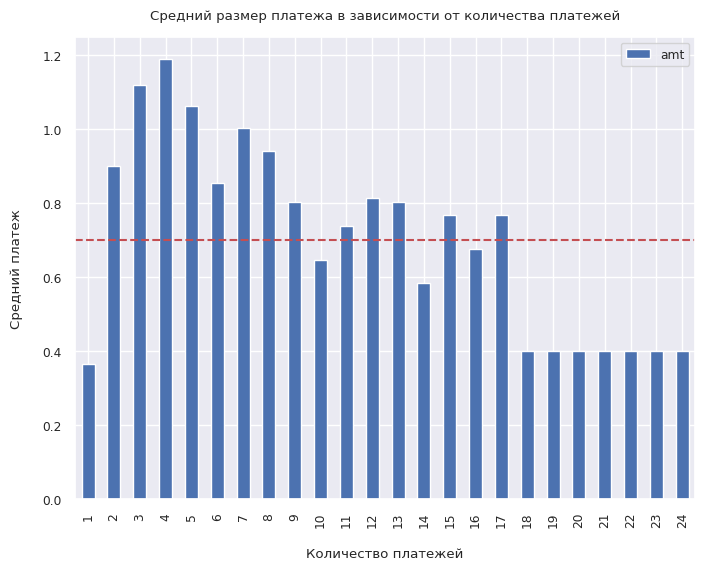

In [150]:
# средний размер платежа в зависимости от количества платежей
payments.groupby('row_number_by_group').agg({'amt':'mean'}).plot(kind='bar')
plt.axhline(y=0.7, color='r', linestyle='--')
plt.ylabel("Средний платеж", labelpad=14)
plt.xlabel("Количество платежей", labelpad=14)
plt.title("Cредний размер платежа в зависимости от количества платежей", y=1.02);
plt.show()


Первый платёж, как правило, тестовый – пользователь хочет почувствовать преимущества платного использования. Если ему нравится, он входит во вкус, и с каждым разом начинает платить всё больше:

* средний размер первого платежа – 0.38 денежных единиц
* средний размер пятого платежа - 1.33 денежные единицы, дальше средний платеж снижается, но до 10 платежа держится на уровне выше среднего по всей выборке данных

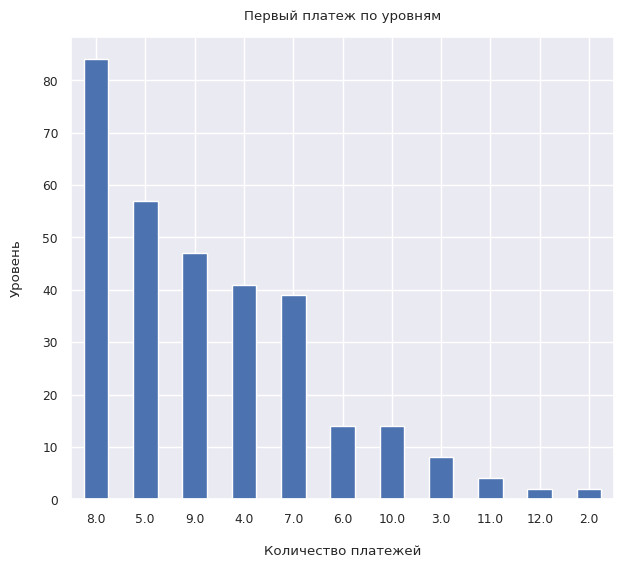

In [151]:
# отберем только первые покупки
payments_1st = payments.query('row_number_by_group == 1')
payments_1st['pay_on_lvl'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Уровень", labelpad=14)
plt.xlabel("Количество платежей", labelpad=14)
plt.title("Первый платеж по уровням", y=1.02);
plt.show()

Пользователи обычно не платят на начальном уровне и после 12го


## Дополнительные метрики, требующие дополнительных данных


#### NPS (Net Promoter Score)
Индекс потребительской лояльности. Метрика отражает приверженность клиентов к приложению, удовлетворенность от его использования.

Реализовывается через опросник, состоящий из одного или нескольких пунктов, каждый из которых оценивается по шкале от 0 (не нравится/не работает) до 10 (готов рекомендовать/всё понравилось). Вопросы формируются индивидуально, на основе предлагаемого продукта. Можно задать и один вопрос: насколько вы готовы порекомендовать приложение своим друзьям/знакомым/коллегам?

Отвечающих делят на несколько категорий:

Критики (0-6 баллов).
Нейтральные (7-8 баллов).
Сторонники (9-10 баллов).



#### Кастомные метрики (метрики фичи)

Например, в случае с мобильным приложением, за фичу можно взять «поисковую панель». Тогда дополнительно можно посчитать:
* Конверсия в фичу. Доля пользователей, которые воспользовались фичей
* Достижение целевого действия. Конверсия в целевое действие из фичи
* Возвращаемость в фичу. Доля пользователей вернувшихся в фичу — retention для фичи.

#### ROI, CAC
Свзянные с затратами на рекламу, о которой в данных нет информации

## Аномалии
* Пользователь, который наиграл более 600 часов за один день
* Пользователь, который купил 24 раза
* Пользователь, который сделал самые дорогие покупки в короткий период (возможно, по ошибке), в сумме составившие 4% от всей выручки

# Выводы

* 44 пользователя (0.14%) зарегистрировались, но не начали игру-обучение
* Данные представлены с 11 по 30 мая, с 22 мая не было зарегистрировано ни одного нового пользователя
* Все игроки, начавшие игру, по умолчанию находятся на первом уровне. Только получив второй уровень, они попадают в таблицу levels. Максимальный уровень – 21. 75% пользователей не поднялись выше 7 уровня.После 17 уровня данные выглядят аномально и объединены в кодовое название «epic» - единицы пользователь достигают таких уровней (только 22 пользователя достигли эпического уровня).

  Принято решение категоризировать уровни:
  Low: уровень 1-6, Middle: уровень 7-11, Hight: уровень 12-16, Epic: уровень c 17 и выше

* Составлена таблица профилей, которая дает следующую информацию
  *	количество зарегистрированных пользователей совпадает с общим размером датасета - 31 114
  * количество пользователей, начавших сессии 31 070, 0.14% человека остановились после регистрации
  *	количество пользователей, получивших хотя бы первый уровень 25 545 (82%)
  *	распределение уровней среди тех, кто получил хотя бы один уровень: 53% на низком уровне (Low - не более 6 уровней), 41% достигли среднего уровня (Middle от 7 до 11 уровней), 6% на высоком уровне (Hight от 12 до 16 уровней) и 0,09% (22 пользователя) достигли "эпического" уровня (Epic - выше 17 уровней)
  *	количество пользователей, совершивших платежи, 1% от все зарегистрировавшихся и 1,2% от тех, кто получил хотя бы один уровень
* Основная часть пользователей (примерно 42%) имеют низкий уровень игры (их уровень не превышает 6), примерно 34% достигли среднего уровня (от 7 до 11), на высоком и эпическом уровне играют около 5%. Главная находка - примерно 18% игроков не перешли на второй уровень, хотя и начинали игру (первый уровень у всех по умолчанию).
* Корреляция между полученным уровнем и количеством сессий составила 72%. Таким образом, чтобы человек играл больше, он должен получать уровни.
* В данных обнаружен пользователь user_id == 931233, который с 21 по 30 мая играл от 1ч.20 минут до 10 часов в день, чем сильно повлиял на средние значения времени игры по уровням, было принято решение исключить его из анализа медианного времени игры и медианного количества сессий для каждого уровня игры
* Время сессий по уровням:
  * Пользователи, не получившие даже первого уровня, в среднем проводят в приложении одну двухминутную сессию (зашли, посмотрели контент, не заинтересовало - вышли и больше не вернулись) - и таких 18%!
  * Пользователи уровня Low проводят 1-2 сессии около 8-9 минут - проходят игру чуть дальше и на каком-то моменте теряют интерес
  * Пользователи среднего уровня Middle в среднем имеют 19 сессий (13 по медиане) и заинтересованы в приложении - проводят там от 14-16 минут
  *	Пользователи высокого уровня Hight в среднем достигали его за 68-72 сессии, среднее время сессии 14-16 минут
  *	Пользователи эпического уровня (таких всего 37) в среднем имеют по 118-128 сессий со средним временем 18-24 минуты

  Значит, чтобы пользователь удерживался в приложении, он должен потратить 14-16 минут за сессии для успешного обучения-прохождения контента
* Медианное время на каждом уровне не превышает 20 минут, но при этом уровни 6 и 7 по временным затратам сравнимы с уровнем 18, а если вспомнить, что это пограничные уровни Low и Middle, а на уровне Low играет 40% пользователей, возможно нужно поработать над контентом или бонусными подсказками для перехода в следующую категорию
* Оказалось, что для некоторых пользователей время начала сессии было до момента регистрации. Возможно, познакомиться с приложением можно без регистрации, но для сохранения уровня - необходимо ее пройти
* Удержание платящих значительно выше удержания неплатящих: к 9 дню retention составлял 43% и 15% соответственно
* Суммарная выручка приложения примерно 500 денежных единиц, метрика ARPU = 0,016 - столько клиент в среднем платит в месяц за наше приложение. Метрика ARPPU  = 1.6 денежных единиц – нельзя сказать, плохо это или хорошо до введения фич или дополнительного периода анализа. Средний чек 0.71 денежных единиц
* Только 1% пользователей приложения сделали покупки, однако среди них 37% совершили две и более покупки
* Какой-то зависимости средней стоимости покупки и уровня нет. Разработчикам стоит обдумать этот момент, почему на разных уровнях получается разная ценовая политика. Что покупают пользователи? Как это помогает проходить им уровни?
* Почти 25% покупок было совершено на 8 уровне (наибольшее значение), также в тройке лидеров 9 и 10 уровень, наименьшее количество на 2, 17 и 19 уровнях.
Минимальное количество покупок - 1, максимальное количество покупок - 24, в среднем пользователи делали 3 покупки, по медиане - 2, 75% платящих пользователей не покупали больше четырёх раз
* В данных есть аномальное количество платежей от одного и того же пользователя (user_id = = 799540). Этот пользователь не достиг высокого уровня игры, зато сделал 24 платежа (начиная с количества 19ти он накручивал нам аномальные данные)

* Первый платёж, как правило, тестовый – пользователь хочет почувствовать преимущества платного использования. Если ему нравится, он входит во вкус, и с каждым разом начинает платить всё больше:
  * средний размер первого платежа – 0.38 денежных единиц
  *	средний размер пятого платежа - 1.33 денежные единицы, дальше средний платеж снижается, но до 10 платежа держится на уровне выше среднего по всей выборке данных

  Пользователи обычно не платят на начальном уровне и после 12го, значит, если пользователь продвинется дальше 12 уровня, не совершив покупки, надеется на это событие уже не придется.






## Рекомендации
1.	Добавить в данные информацию о затратах на рекламу для полного анализа
2.	Разобраться, как стимулировать пропавших после регистрации пользователей, вернуться к игре (письма-напоминания, акции ко дню рождения, игровые трофеи или значки)
3.	Разобраться с ценовой политикой, почему средний доход на разных уровнях разный
4.	Проверить сложность уровней, при переходе из Low в Middle: если пользователи не будут завершать уровни, им будет не интересно играть
5.	18% не апнули второй уровень – почему им было не интересно, как их завлечь? (добавить значки, ачивки, трекер выполнения, рейтинговую таблицу, эпическую рамку на аватарке и др.)
